# Figure 8 - US frequency and sonophore radius dependent excitation thresholds

Compute (DC x amplitude) threshold curves of RS and LTS neurons for various sonophore radii and US frequencies, from SONIC model predictions.

### Imports

In [1]:
import os
import logging
import numpy as np
import matplotlib.pyplot as plt
from PySONIC.utils import logger
from PySONIC.neurons import getPointNeuron
from PySONIC.core import NeuronalBilayerSonophore, AcousticDrive, PulsedProtocol, Batch
from PySONIC.utils import isIterable, si_format
from PySONIC.plt import cm2inch
from utils import saveFigsAsPDF

logger.setLevel(logging.INFO)

### Functions

In [3]:
def getThresholds(nbls, drive, tstim, toffset, PRF, DCs):
    ''' Get thresholds for a given DC range. '''
    queue = [[drive, PulsedProtocol(tstim, toffset, PRF, DC), cov, 'sonic', None] for DC in DCs]
    batch = Batch(nbls.titrate, queue)
    return np.array(batch.run(mpi=True, loglevel=logger.level))


def plotThresholdAmps(pneurons, radii, freqs, tstim, toffset, PRF, DCs, cov,
                      fs=10, colors=None, figsize=cm2inch(10, 8)):
    ''' Plot threshold excitation amplitudes of several neurons determined by titration procedures,
        as a function of duty cycle, for various combinations of sonophore radius and US frequency.

        :param neurons: list of neuron names
        :param radii: list of sonophore radii (m)
        :param freqs: list US frequencies (Hz)
        :param PRF: pulse repetition frequency used for titration procedures (Hz)
        :param tstim: stimulus duration used for titration procedures
        :return: figure handle
    '''
    if isIterable(radii) and isIterable(freqs):
        raise ValueError('cannot plot threshold curves for more than 1 varying condition')
    if len(pneurons) > 3:
        raise ValueError('cannot plot threshold curves for more than 3 neuron types')

    if not isIterable(radii):
        radii = [radii]
    if not isIterable(freqs):
        freqs = [freqs]
    ncomb = len(pneurons) * len(freqs) * len(radii)
    if colors is None:
        colors = ['C{}'.format(i) for i in range(ncomb)]

    linestyles = ['--', ':', '-.']
    assert len(freqs) <= len(linestyles), 'too many frequencies'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('Duty cycle (%)', fontsize=fs)
    ax.set_ylabel('Amplitude (kPa)', fontsize=fs)
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    ax.set_yscale('log')
    ax.set_xlim([0, 100])
    ax.set_ylim([10, 600])
    linestyles = ['-', '--', '-.']
    for pneuron, ls in zip(pneurons, linestyles):
        icolor = 0
        for i, a in enumerate(radii):
            nbls = NeuronalBilayerSonophore(a, pneuron)
            for j, Fdrive in enumerate(freqs):
                Athrs = getThresholds(nbls, AcousticDrive(Fdrive), tstim, toffset, PRF, DCs)
                lbl = '{} neuron, {:.0f} nm, {}Hz, {}Hz PRF'.format(
                    pneuron.name, a * 1e9, *si_format([Fdrive, PRF]))
                ax.plot(DCs * 1e2, Athrs * 1e-3, ls, c=colors[icolor], label=lbl)
                icolor += 1
    ax.legend(fontsize=fs - 2, frameon=False)
    fig.tight_layout()
    return fig

### Plot parameters

In [4]:
figindex = 8
figsize=cm2inch(15, 12)
fs = 14
cmap = plt.get_cmap('tab20c').colors
figs = {}

### Simulation parameters

In [5]:
a = 32e-9       # m
Fdrive = 500e3  # Hz
tstim = 1.0     # s
toffset = 0.0   # s
PRF = 100.0     # s
cov = 1.0
DCs = np.arange(1, 101) * 1e-2

neurons = ['RS', 'LTS']
pneurons = [getPointNeuron(x) for x in neurons]

## Panel A: sonophore radius-dependent threshold curves

In [ ]:
radii = np.array([16, 32, 64]) * 1e-9  # m
colors = cmap[:3][::-1]
fig = plotThresholdAmps(pneurons, radii, Fdrive, tstim, toffset, PRF, DCs, cov, colors=colors, fs=fs, figsize=figsize)
figs['a'] = fig

## Panel B: frequency-dependent threshold curves

 28/04/2020 21:13:50: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 20kHz, A = 10.00kPa, tstim = 1s, PRF = 100.00Hz, DC = 1.0%
 28/04/2020 21:13:52: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 20kHz, A = 600.00kPa, tstim = 1s, PRF = 100.00Hz, DC = 1.0%


KeyboardInterrupt: 

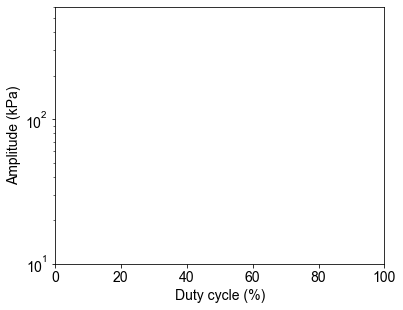

In [20]:
freqs = np.array([20, 500, 4000]) * 1e3  # Hz
colors = cmap[8:11][::-1]
fig = plotThresholdAmps(pneurons, a, freqs, tstim, toffset, PRF, DCs, cov, colors=colors, fs=fs, figsize=figsize)
figs['b'] = fig

### Save figure panels

Save figure panels as **pdf** in the *figs* sub-folder:

In [8]:
saveFigsAsPDF(figs, figindex)